# **Brain Tumor Classification (MRI)**

### Packages

In [1]:
# Import relevant packages
import pandas as pd
import os
import cv2
import numpy as np
from tqdm import tqdm
import matplotlib.pyplot as plt
import torch

### **Data Extraction**
---

In [2]:
# Define labels
labels = ['glioma_tumor', 'no_tumor', 'meningioma_tumor', 'pituitary_tumor']

# Initialize lists 
X = []  # images
y = []  # labels

# Resize images
image_size = 150 

# Define path for data
data_path = "/home/nico/Documents/Python/BMI_I2_Final_Project/Data"

# Loop through labels
for label in labels:
    folderPath = os.path.join(data_path, label)
    
    # Loop through all images
    for filename in tqdm(os.listdir(folderPath)):
        img = cv2.imread(os.path.join(folderPath, filename))
        
        # Only add valid images
        if img is not None:
            img = cv2.resize(img, (image_size, image_size))  
            X.append(img)
            y.append(label)

100%|██████████| 901/901 [00:02<00:00, 383.41it/s]


In [21]:
pd.Series(y).value_counts()

meningioma_tumor    937
glioma_tumor        926
pituitary_tumor     901
no_tumor            500
Name: count, dtype: int64

In [3]:
# Convert to numpy array
X = np.array(X)
y = np.array(y)

print(f"Shape of the image data {X.shape}")
print(f"Shape of the label data {y.shape}")

Shape of the image data (3264, 150, 150, 3)
Shape of the label data (3264,)


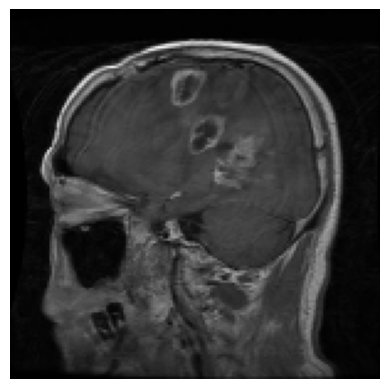

Label for the first image: glioma_tumor


In [4]:
# Display the first image
plt.imshow(X[0]) 
plt.axis('off') 
plt.show()
print(f"Label for the first image: {y[0]}")

### **Data Validation**
---

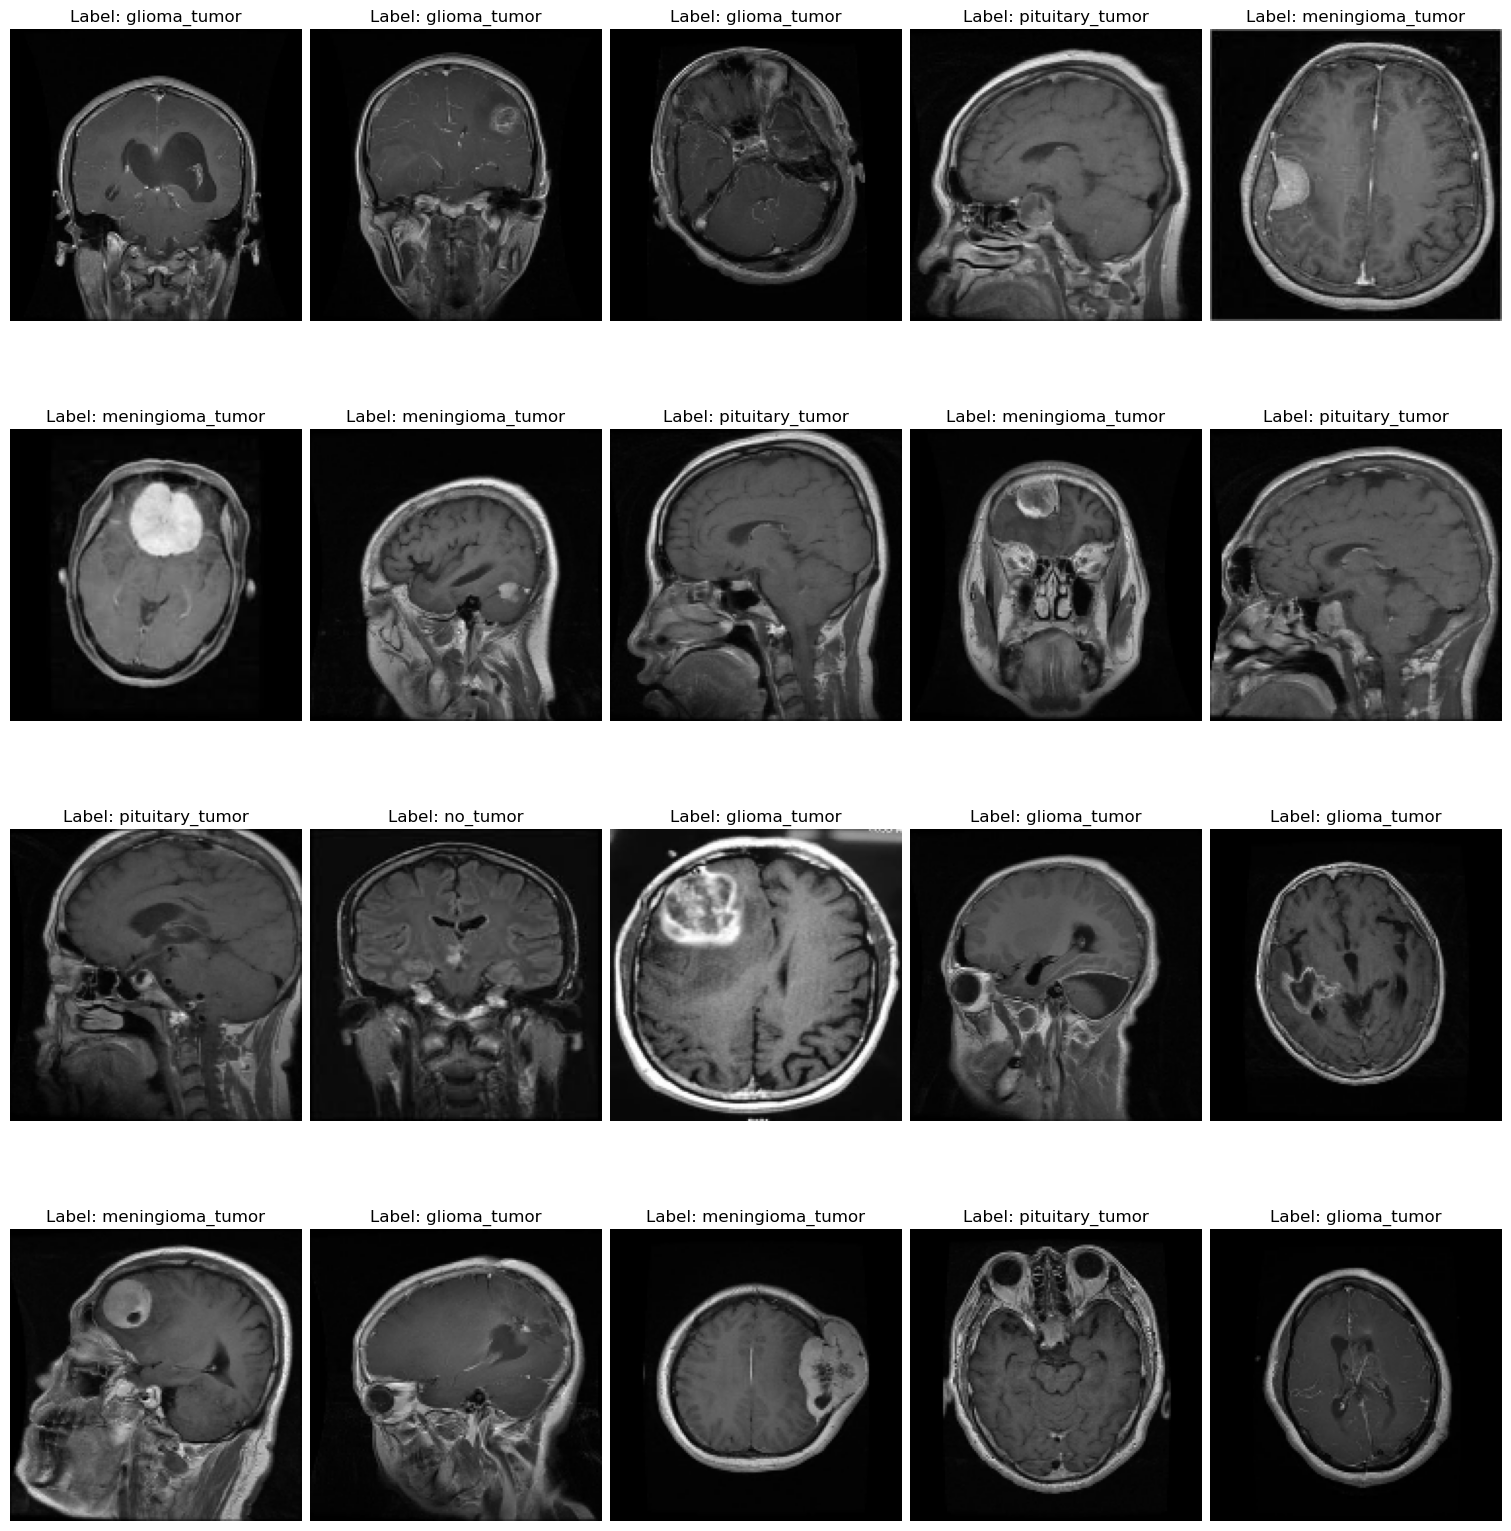

In [5]:
# Set up the plot grid
num_cols = 5
num_rows = 4
fig, axes = plt.subplots(num_rows, num_cols, figsize=(15, num_rows * 4), constrained_layout=True)

# List of indices for random images
indices = [99, 311, 435, 3001, 2258, 1832, 1754, 3211, 1911, 2831, 
           2812, 1200, 431, 394, 871, 2193, 48, 1912, 3011, 9]

# Flatten the axes
axes = axes.flatten()

# Loop through 20 images
for ax, i in zip(axes, indices):
    ax.imshow(X[i], cmap='gray') 
    ax.axis('off')
    ax.set_title(f"Label: {y[i]}") 

# Show the full figure
plt.show()

### **Convert NumPy Arrays to PyTorch Tensors**
---

In [6]:
# Import relevant packages
from torch.utils.data import TensorDataset, DataLoader
import torchvision.transforms as transforms
from sklearn.model_selection import train_test_split

In [7]:
# Normalize image data
X = X.astype("float32") / 255.0

# Convert labels to numerical values
label_mapping = {label: idx for idx, label in enumerate(['glioma_tumor', 'no_tumor', 'meningioma_tumor', 'pituitary_tumor'])}
y_numeric = np.array([label_mapping[label] for label in y])

# Convert NumPy arrays to PyTorch tensors
X_tensor = torch.tensor(X).permute(0, 3, 1, 2)  
y_tensor = torch.tensor(y_numeric, dtype=torch.long)  

print(f"Image tensor shape: {X_tensor.shape}")  
print(f"Label tensor shape: {y_tensor.shape}") 

# Split dataset into training and testing sets (80% train, 20% test)
X_train, X_test, y_train, y_test = train_test_split(X_tensor, y_tensor, test_size=0.2, random_state=42)

# Wrap data into TensorDataset
train_dataset = TensorDataset(X_train, y_train)
test_dataset = TensorDataset(X_test, y_test)

# Create DataLoaders
BATCH_SIZE = 32
train_loader = DataLoader(train_dataset, batch_size=BATCH_SIZE, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=BATCH_SIZE, shuffle=False)

Image tensor shape: torch.Size([3264, 3, 150, 150])
Label tensor shape: torch.Size([3264])


In [22]:
# Get counts for each label in train and test sets
train_counts = torch.bincount(y_train)
test_counts = torch.bincount(y_test)

# Map indices back to label names
idx_to_label = {v: k for k, v in label_mapping.items()}

# Create DataFrame
label_stats = pd.DataFrame({
    'Label': [idx_to_label[i] for i in range(len(train_counts))],
    'Train Count': train_counts.tolist(),
    'Test Count': test_counts.tolist()
})

# Add total and percentage if you'd like
label_stats['Total'] = label_stats['Train Count'] + label_stats['Test Count']
label_stats['Train %'] = 100 * label_stats['Train Count'] / label_stats['Total']
label_stats['Test %'] = 100 * label_stats['Test Count'] / label_stats['Total']

print(label_stats)

              Label  Train Count  Test Count  Total    Train %     Test %
0      glioma_tumor          712         214    926  76.889849  23.110151
1          no_tumor          402          98    500  80.400000  19.600000
2  meningioma_tumor          769         168    937  82.070438  17.929562
3   pituitary_tumor          728         173    901  80.799112  19.200888


### **Define CNN Model**
---

In [8]:
# Import relevant functions 
import torch.nn as nn
import torch.nn.functional as F

In [9]:
# Create architecture
class BrainTumorCNN(nn.Module):
    def __init__(self):
        super(BrainTumorCNN, self).__init__()
        
        self.conv1 = nn.Sequential(
            nn.Conv2d(3, 16, kernel_size=3, stride=1, padding=1),  # (16, 150, 150)
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2, stride=2)  # (16, 75, 75)
        )
        self.conv2 = nn.Sequential(
            nn.Conv2d(16, 32, kernel_size=3, stride=1, padding=1),  # (32, 75, 75)
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2, stride=2)  # (32, 37, 37)
        )
        self.conv3 = nn.Sequential(
            nn.Conv2d(32, 64, kernel_size=3, stride=1, padding=1),  # (64, 37, 37)
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2, stride=2)  # (64, 18, 18)
        )
        
        self.fc1 = nn.Linear(64 * 18 * 18, 128)
        self.fc2 = nn.Linear(128, 4)  # 4 classes

    def forward(self, x):
        x = self.conv1(x)
        x = self.conv2(x)
        x = self.conv3(x)
        x = x.view(x.size(0), -1)  # Flatten
        x = F.relu(self.fc1(x))
        x = self.fc2(x)  # No activation
        return x
    
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = BrainTumorCNN().to(device)

CNN Model Architecture Description:

Three convolutional layers followed by two fully connected (dense) layers. 

### **Train CNN Model**
---

In [10]:
# Import relevant functions 
import torch.optim as optim
from tqdm import tqdm

In [11]:
# Define loss function and optimizer
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)
num_epochs = 10

# Train
for epoch in range(num_epochs):
    model.train()
    train_loss = 0.0
    train_correct = 0

    with tqdm(train_loader, unit="batch") as tepoch:
        for images, labels in tepoch:
            images, labels = images.to(device), labels.to(device)

            # Forward pass
            outputs = model(images)
            loss = criterion(outputs, labels)

            # Backpropagation
            optimizer.zero_grad()
            loss.backward()
            optimizer.step()

            train_loss += loss.item()
            preds = torch.argmax(outputs, dim=1)
            train_correct += (preds == labels).sum().item()

            tepoch.set_postfix(loss=train_loss / len(train_loader), accuracy=100 * train_correct / (BATCH_SIZE * len(train_loader)))

    print(f"Epoch {epoch+1}/{num_epochs}, Loss: {train_loss / len(train_loader):.4f}, Accuracy: {100 * train_correct / len(train_dataset):.2f}%")

100%|██████████| 82/82 [00:01<00:00, 51.15batch/s, accuracy=55.6, loss=1.02]  


Epoch 1/10, Loss: 1.0163, Accuracy: 55.88%


100%|██████████| 82/82 [00:01<00:00, 64.88batch/s, accuracy=71.2, loss=0.691]


Epoch 2/10, Loss: 0.6910, Accuracy: 71.58%


100%|██████████| 82/82 [00:01<00:00, 64.11batch/s, accuracy=79.8, loss=0.506] 


Epoch 3/10, Loss: 0.5056, Accuracy: 80.16%


100%|██████████| 82/82 [00:01<00:00, 63.06batch/s, accuracy=87.5, loss=0.339] 


Epoch 4/10, Loss: 0.3387, Accuracy: 87.94%


100%|██████████| 82/82 [00:01<00:00, 62.26batch/s, accuracy=91.5, loss=0.224] 


Epoch 5/10, Loss: 0.2244, Accuracy: 91.96%


100%|██████████| 82/82 [00:01<00:00, 61.67batch/s, accuracy=95, loss=0.132]   


Epoch 6/10, Loss: 0.1315, Accuracy: 95.44%


100%|██████████| 82/82 [00:01<00:00, 62.66batch/s, accuracy=95.5, loss=0.111] 


Epoch 7/10, Loss: 0.1108, Accuracy: 96.02%


100%|██████████| 82/82 [00:01<00:00, 61.99batch/s, accuracy=96.9, loss=0.0835]


Epoch 8/10, Loss: 0.0835, Accuracy: 97.40%


100%|██████████| 82/82 [00:01<00:00, 64.14batch/s, accuracy=98.5, loss=0.0349]


Epoch 9/10, Loss: 0.0349, Accuracy: 98.97%


100%|██████████| 82/82 [00:01<00:00, 63.13batch/s, accuracy=99.2, loss=0.016]  

Epoch 10/10, Loss: 0.0160, Accuracy: 99.66%


### **Evaluate CNN Model**
---

In [12]:
# Accuracy
model.eval()
test_correct = 0

with torch.no_grad():
    for images, labels in test_loader:
        images, labels = images.to(device), labels.to(device)

        outputs = model(images)
        preds = torch.argmax(outputs, dim=1)
        test_correct += (preds == labels).sum().item()

print(f"Test Accuracy: {100 * test_correct / len(test_dataset):.2f}%")

Test Accuracy: 89.74%


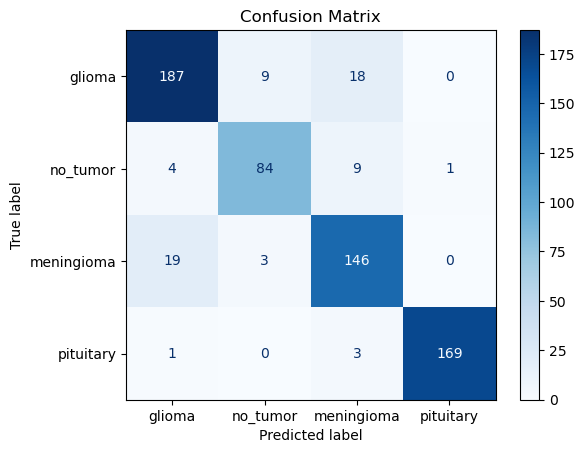

In [13]:
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay

# Class index to label mapping
idx_to_label = {
    0: 'glioma',
    1: 'no_tumor',
    2: 'meningioma',
    3: 'pituitary'
}

# Collect all predictions and true labels
all_preds = []
all_labels = []

model.eval()
with torch.no_grad():
    for images, labels in test_loader:
        images = images.to(device)
        outputs = model(images)
        preds = torch.argmax(outputs, dim=1).cpu().numpy()
        all_preds.extend([idx_to_label[p] for p in preds])
        all_labels.extend([idx_to_label[l.item()] for l in labels])

# Compute confusion matrix
labels = ['glioma', 'no_tumor', 'meningioma', 'pituitary']
cm = confusion_matrix(all_labels, all_preds, labels=labels)
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=labels)
disp.plot(cmap='Blues')
plt.title("Confusion Matrix")
plt.show()

In [14]:
# Precision and accuracy
from sklearn.metrics import classification_report

print(classification_report(all_labels, all_preds, target_names=labels))

              precision    recall  f1-score   support

      glioma       0.89      0.87      0.88       214
    no_tumor       0.83      0.87      0.85       168
  meningioma       0.88      0.86      0.87        98
   pituitary       0.99      0.98      0.99       173

    accuracy                           0.90       653
   macro avg       0.90      0.89      0.90       653
weighted avg       0.90      0.90      0.90       653



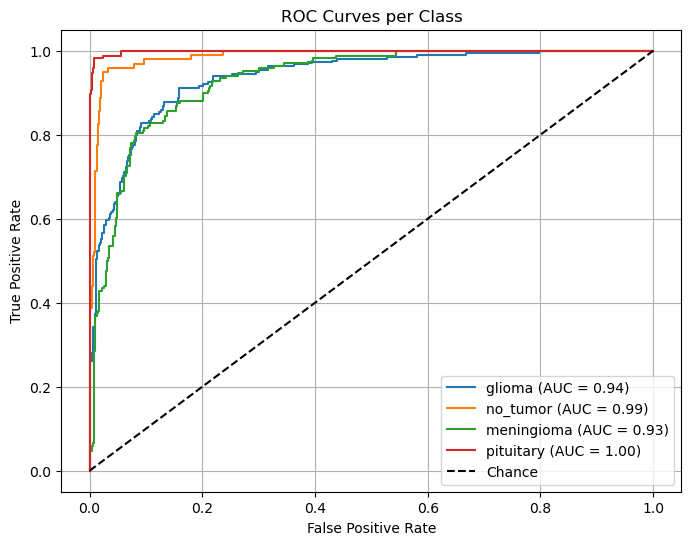

In [15]:
from sklearn.metrics import roc_curve, auc
from sklearn.preprocessing import label_binarize
import matplotlib.pyplot as plt

# Mapping: class index to name
idx_to_label = {
    0: 'glioma',
    1: 'no_tumor',
    2: 'meningioma',
    3: 'pituitary'
}

# Reverse mapping: name to index
label_to_idx = {v: k for k, v in idx_to_label.items()}

# Labels list
labels = ['glioma', 'no_tumor', 'meningioma', 'pituitary']

# Convert string labels back to numeric for binarization
y_true = label_binarize([label_to_idx[l] for l in all_labels], classes=[0, 1, 2, 3])

# Collect model output scores
y_score = []

model.eval()
with torch.no_grad():
    for images, _ in test_loader:
        images = images.to(device)
        outputs = model(images)
        y_score.append(outputs.cpu().numpy())

# Convert to full array
y_score = np.concatenate(y_score, axis=0)

# Plot ROC for each class
plt.figure(figsize=(8, 6))
for i in range(len(labels)):
    fpr, tpr, _ = roc_curve(y_true[:, i], y_score[:, i])
    roc_auc = auc(fpr, tpr)
    plt.plot(fpr, tpr, label=f'{labels[i]} (AUC = {roc_auc:.2f})')

# Plot chance line
plt.plot([0, 1], [0, 1], 'k--', label='Chance')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curves per Class')
plt.legend(loc='lower right')
plt.grid(True)
plt.show()
